<a href="https://colab.research.google.com/github/cicbeast/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [3]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [4]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=29.1801224355095, mobile=True), User(purchased=False, time_on_site=369.6394197006996, mobile=False), User(purchased=False, time_on_site=73.15366258244408, mobile=True), User(purchased=False, time_on_site=253.5791820777811, mobile=True), User(purchased=True, time_on_site=233.7432981948477, mobile=True), User(purchased=False, time_on_site=188.09745539768284, mobile=True), User(purchased=True, time_on_site=208.49753082827013, mobile=True), User(purchased=False, time_on_site=112.92381234675541, mobile=True), User(purchased=False, time_on_site=176.2598182815007, mobile=False), User(purchased=False, time_on_site=553.6690649640425, mobile=False)]


In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,29.180122,True
1,False,369.639420,False
2,False,73.153663,True
3,False,253.579182,True
4,True,233.743298,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.8275105666257865,5.9024826635960705,6.21618399378243,6.881398469499255,6.941603141546298,7.443425774278419,7.568478477641314,7.924738574849633,8.712840454318632,8.954552636596183,...,573.5054567168929,574.407525483297,576.2289704937499,577.8699958527379,578.5984554983297,580.1251406726235,580.6441389209185,587.1338954820967,591.273975076619,594.0186889467586
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,0,...,1,0,1,1,1,0,1,0,1,0
True,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,1


In [9]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(5.239, 123.466]",248,94
"(123.466, 241.104]",193,157
"(241.104, 358.742]",118,83
"(358.742, 476.38]",33,22
"(476.38, 594.019]",29,23


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(5.239, 123.466]",0.399356,0.248021
"(123.466, 241.104]",0.310789,0.414248
"(241.104, 358.742]",0.190016,0.218997
"(358.742, 476.38]",0.053140,0.058047
"(476.38, 594.019]",0.046699,0.060686


In [11]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.692,0.597333
True,0.308,0.402667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# First the imports (even though they were done above)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# Let's grab the data from the provided persons csv
persons_url = 'https://raw.githubusercontent.com/alexkimxyz/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'

persons_data = pd.read_csv(persons_url)

# We'll take a sample to see how it looks
persons_data.sample(10)

,Unnamed: 0,age,weight,exercise_time
1108,1108,18,116,199
327,327,29,132,249
98,98,55,199,132
498,498,20,154,86
768,768,56,132,210
1037,1037,56,166,122
1187,1187,48,160,125
567,567,51,148,140
672,672,52,134,74
977,977,48,194,13


In [14]:
# It looks like the index is repeating as a data column.
# Let's fix that

# We'll use the reassign method rather than inplace
persons_data = persons_data.drop(persons_data.columns[0], axis=1)

# We'll take another sample to make sure we got it
persons_data.sample(10)

,age,weight,exercise_time
512,28,210,38
316,64,132,108
528,35,126,297
457,44,176,69
1100,39,116,162
50,61,193,71
240,53,150,275
687,31,156,270
31,40,168,115
640,49,133,22


In [15]:
# Alright, now what kind of data are we dealing with
persons_data.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [16]:
# That is SUPER convenient for us
# Now let's just make sure that the dataframe is clean

persons_data.dtypes.value_counts()

int64    3
dtype: int64

In [17]:
persons_data.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

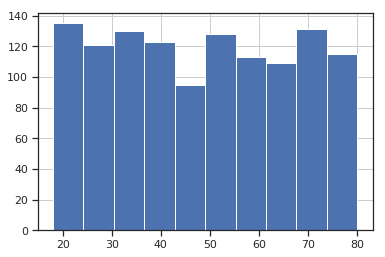

In [18]:
# GREAT!
# Knowing that we have all integers, lets do some visualizations

persons_data['age'].hist()

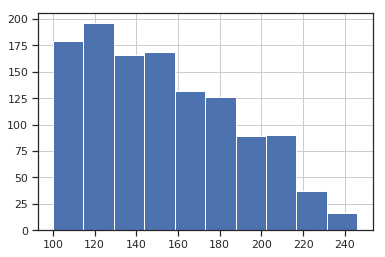

In [19]:
persons_data['weight'].hist()

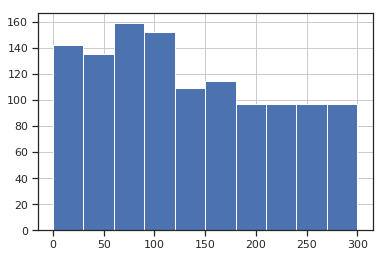

In [20]:
persons_data['exercise_time'].hist()

<BarContainer object of 1200 artists>

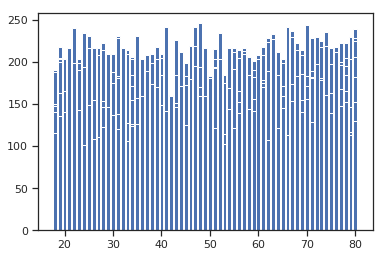

In [21]:
# Now that we have an idea about how each attribute is distributed, lets do some comparisons
# First let's use visualizations

plt.bar(persons_data['age'], persons_data['weight'])

<BarContainer object of 1200 artists>

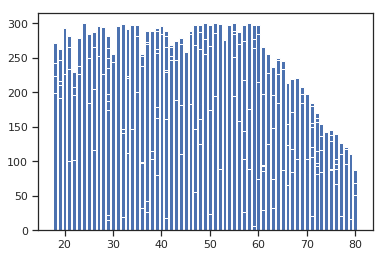

In [22]:
plt.bar(persons_data['age'], persons_data['exercise_time'])

<BarContainer object of 1200 artists>

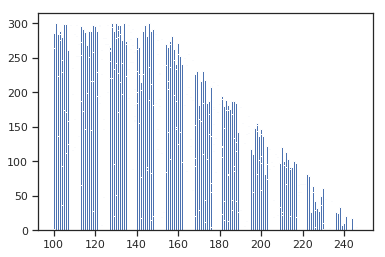

In [23]:
plt.bar(persons_data['weight'], persons_data['exercise_time'])

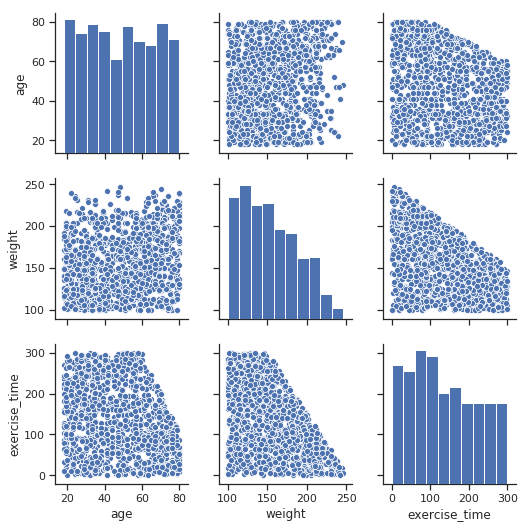

In [24]:
# As per my breakout group, let's look at a pairplot
import seaborn as sns

sns.set(style='ticks', color_codes=True)
sns.pairplot(persons_data)

In [0]:
# We can see some trends in the data, but let's compare using crosstab 
# Let's put age into 12 equal bins

age_bins = pd.cut(persons_data['age'], bins = 12)

In [26]:
pd.crosstab(age_bins, persons_data['weight'], normalize = 'all')

weight,100,101,102,103,104,105,106,107,108,109,...,234,236,237,238,239,240,241,242,244,246
age,,,,,,,,,,,,,,,,,,,,,
"(17.938, 23.167]",0.000000,0.000833,0.001667,0.000000,0.000833,0.000000,0.000833,0.000833,0.002500,0.000833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,0.000000
"(23.167, 28.333]",0.000000,0.001667,0.000833,0.000833,0.000833,0.000833,0.000833,0.000000,0.001667,0.000833,...,0.000833,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(28.333, 33.5]",0.001667,0.000833,0.001667,0.000000,0.000000,0.001667,0.001667,0.000000,0.000833,0.001667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(33.5, 38.667]",0.001667,0.001667,0.000833,0.000833,0.000000,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(38.667, 43.833]",0.000833,0.000833,0.001667,0.000833,0.001667,0.000833,0.000000,0.002500,0.000833,0.001667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000
"(43.833, 49.0]",0.000000,0.000833,0.000833,0.000833,0.001667,0.000000,0.000000,0.000000,0.002500,0.000000,...,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000,0.000833
"(49.0, 54.167]",0.000833,0.000000,0.001667,0.000833,0.000000,0.000833,0.000000,0.001667,0.001667,0.001667,...,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(54.167, 59.333]",0.002500,0.000000,0.000000,0.000833,0.000000,0.000833,0.000000,0.001667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(59.333, 64.5]",0.000833,0.001667,0.000000,0.000000,0.000000,0.001667,0.000000,0.000833,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
# Not very helpful
# Let's put weight into bins also
weight_bins = pd.cut(persons_data['weight'], bins = 14)
pd.crosstab(age_bins, weight_bins.astype(str), normalize='all')


weight,"(110.429, 120.857]","(120.857, 131.286]","(131.286, 141.714]","(141.714, 152.143]","(152.143, 162.571]","(162.571, 173.0]","(173.0, 183.429]","(183.429, 193.857]","(193.857, 204.286]","(204.286, 214.714]","(214.714, 225.143]","(225.143, 235.571]","(235.571, 246.0]","(99.854, 110.429]"
age,,,,,,,,,,,,,,
"(17.938, 23.167]",0.012500,0.009167,0.012500,0.008333,0.011667,0.010000,0.006667,0.006667,0.008333,0.000833,0.001667,0.000000,0.000833,0.009167
"(23.167, 28.333]",0.011667,0.009167,0.007500,0.009167,0.009167,0.005833,0.002500,0.000833,0.001667,0.004167,0.003333,0.001667,0.000833,0.008333
"(28.333, 33.5]",0.014167,0.006667,0.011667,0.008333,0.008333,0.012500,0.005000,0.005833,0.000833,0.005833,0.001667,0.001667,0.000000,0.010833
"(33.5, 38.667]",0.011667,0.015833,0.004167,0.008333,0.009167,0.000833,0.005833,0.005000,0.006667,0.005000,0.000000,0.001667,0.000000,0.013333
"(38.667, 43.833]",0.006667,0.011667,0.010000,0.008333,0.007500,0.003333,0.004167,0.004167,0.005000,0.001667,0.001667,0.000833,0.000833,0.014167
"(43.833, 49.0]",0.006667,0.014167,0.015000,0.005833,0.005833,0.010000,0.005000,0.002500,0.005000,0.004167,0.002500,0.000000,0.002500,0.007500
"(49.0, 54.167]",0.006667,0.012500,0.005000,0.006667,0.001667,0.006667,0.006667,0.004167,0.003333,0.001667,0.001667,0.000833,0.000000,0.010833
"(54.167, 59.333]",0.009167,0.012500,0.007500,0.011667,0.008333,0.005833,0.006667,0.005000,0.005000,0.005833,0.001667,0.000000,0.000000,0.005833
"(59.333, 64.5]",0.005000,0.005833,0.013333,0.006667,0.007500,0.005833,0.006667,0.004167,0.007500,0.004167,0.001667,0.002500,0.000000,0.005833


In [28]:
#Let's do this for exercise time also
exercise_bins = pd.cut(persons_data['exercise_time'], bins = 15)
pd.crosstab(age_bins, exercise_bins.astype(str), normalize='all')


exercise_time,"(-0.3, 20.0]","(100.0, 120.0]","(120.0, 140.0]","(140.0, 160.0]","(160.0, 180.0]","(180.0, 200.0]","(20.0, 40.0]","(200.0, 220.0]","(220.0, 240.0]","(240.0, 260.0]","(260.0, 280.0]","(280.0, 300.0]","(40.0, 60.0]","(60.0, 80.0]","(80.0, 100.0]"
age,,,,,,,,,,,,,,,
"(17.938, 23.167]",0.003333,0.009167,0.008333,0.008333,0.007500,0.008333,0.007500,0.006667,0.009167,0.002500,0.005000,0.002500,0.005000,0.009167,0.005833
"(23.167, 28.333]",0.003333,0.001667,0.003333,0.006667,0.004167,0.007500,0.004167,0.006667,0.003333,0.009167,0.005833,0.005000,0.007500,0.001667,0.005833
"(28.333, 33.5]",0.007500,0.005000,0.004167,0.005833,0.008333,0.006667,0.009167,0.003333,0.009167,0.007500,0.005000,0.007500,0.005833,0.004167,0.004167
"(33.5, 38.667]",0.006667,0.006667,0.002500,0.002500,0.009167,0.008333,0.007500,0.004167,0.003333,0.005000,0.003333,0.006667,0.007500,0.001667,0.012500
"(38.667, 43.833]",0.005833,0.005833,0.001667,0.004167,0.005000,0.001667,0.005000,0.005000,0.007500,0.007500,0.007500,0.006667,0.003333,0.008333,0.005000
"(43.833, 49.0]",0.005833,0.005000,0.003333,0.005000,0.005000,0.005833,0.002500,0.005833,0.002500,0.010833,0.010000,0.005000,0.007500,0.006667,0.005833
"(49.0, 54.167]",0.004167,0.003333,0.005833,0.004167,0.005000,0.005000,0.003333,0.000833,0.003333,0.003333,0.010833,0.007500,0.004167,0.004167,0.003333
"(54.167, 59.333]",0.005833,0.005833,0.005000,0.003333,0.007500,0.003333,0.004167,0.007500,0.005833,0.004167,0.008333,0.006667,0.002500,0.008333,0.006667
"(59.333, 64.5]",0.007500,0.005833,0.003333,0.005000,0.004167,0.008333,0.007500,0.004167,0.005833,0.002500,0.000833,0.001667,0.000833,0.010833,0.008333


In [29]:
# weight vs exercise
pd.crosstab(weight_bins, exercise_bins.astype(str), normalize='all')


exercise_time,"(-0.3, 20.0]","(100.0, 120.0]","(120.0, 140.0]","(140.0, 160.0]","(160.0, 180.0]","(180.0, 200.0]","(20.0, 40.0]","(200.0, 220.0]","(220.0, 240.0]","(240.0, 260.0]","(260.0, 280.0]","(280.0, 300.0]","(40.0, 60.0]","(60.0, 80.0]","(80.0, 100.0]"
weight,,,,,,,,,,,,,,,
"(99.854, 110.429]",0.006667,0.005833,0.008333,0.006667,0.010833,0.008333,0.003333,0.008333,0.007500,0.005000,0.009167,0.010833,0.005000,0.007500,0.005000
"(110.429, 120.857]",0.003333,0.005000,0.005000,0.006667,0.005000,0.008333,0.007500,0.005000,0.005833,0.009167,0.010000,0.012500,0.005833,0.003333,0.004167
"(120.857, 131.286]",0.005000,0.011667,0.002500,0.005000,0.010833,0.008333,0.005833,0.007500,0.010833,0.013333,0.015000,0.010000,0.005000,0.005833,0.009167
"(131.286, 141.714]",0.002500,0.004167,0.005000,0.011667,0.006667,0.006667,0.005000,0.010000,0.008333,0.009167,0.011667,0.007500,0.004167,0.010000,0.005833
"(141.714, 152.143]",0.006667,0.003333,0.003333,0.005000,0.010833,0.009167,0.007500,0.004167,0.005000,0.005000,0.005833,0.007500,0.002500,0.006667,0.010833
"(152.143, 162.571]",0.005000,0.008333,0.004167,0.008333,0.005000,0.002500,0.004167,0.007500,0.007500,0.009167,0.005000,0.000833,0.003333,0.009167,0.013333
"(162.571, 173.0]",0.007500,0.008333,0.004167,0.006667,0.006667,0.008333,0.005000,0.003333,0.005833,0.002500,0.000000,0.000000,0.005833,0.008333,0.010833
"(173.0, 183.429]",0.004167,0.008333,0.008333,0.003333,0.006667,0.005000,0.005833,0.003333,0.000000,0.000000,0.000000,0.000000,0.005833,0.010000,0.010000
"(183.429, 193.857]",0.008333,0.005833,0.005000,0.004167,0.003333,0.003333,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.005833,0.006667


In [30]:
# And finally all 3
pd.crosstab(weight_bins, [age_bins.astype(str), exercise_bins.astype(str)], normalize='all')


age                (17.938, 23.167]                                \
exercise_time          (-0.3, 20.0] (100.0, 120.0] (120.0, 140.0]   
weight                                                              
(99.854, 110.429]          0.000000       0.000000       0.000833   
(110.429, 120.857]         0.000000       0.000833       0.000833   
(120.857, 131.286]         0.000833       0.002500       0.000000   
(131.286, 141.714]         0.000000       0.000000       0.001667   
(141.714, 152.143]         0.000000       0.000833       0.000833   
(152.143, 162.571]         0.000000       0.000833       0.000833   
(162.571, 173.0]           0.000000       0.000833       0.000000   
(173.0, 183.429]           0.000833       0.000000       0.000833   
(183.429, 193.857]         0.000833       0.000833       0.001667   
(193.857, 204.286]         0.000000       0.001667       0.000833   
(204.286, 214.714]         0.000000       0.000000       0.000000   
(214.714, 225.143]         0.000000       0.000833       0.000000   
(225.143, 235.571]         0.000000       0.000000       0.000000   
(235.571, 246.0]           0.000833       0.000000       0.000000   

age                                                                           \
exercise_time      (140.0, 160.0] (160.0, 180.0] (180.0, 200.0] (20.0, 40.0]   
weight                                                                         
(99.854, 110.429]        0.000833       0.001667       0.001667     0.000000   
(110.429, 120.857]       0.000833       0.000833       0.001667     0.000833   
(120.857, 131.286]       0.000833       0.000000       0.000000     0.000833   
(131.286, 141.714]       0.001667       0.000833       0.000833     0.001667   
(141.714, 152.143]       0.000000       0.000833       0.001667     0.000000   
(152.143, 162.571]       0.000833       0.000833       0.000833     0.000000   
(162.571, 173.0]         0.000833       0.000833       0.001667     0.000833   
(173.0, 183.429]         0.000833       0.000833       0.000000     0.000000   
(183.429, 193.857]       0.000833       0.000000       0.000000     0.001667   
(193.857, 204.286]       0.000833       0.000833       0.000000     0.000833   
(204.286, 214.714]       0.000000       0.000000       0.000000     0.000000   
(214.714, 225.143]       0.000000       0.000000       0.000000     0.000833   
(225.143, 235.571]       0.000000       0.000000       0.000000     0.000000   
(235.571, 246.0]         0.000000       0.000000       0.000000     0.000000   

age                                                              ...  \
exercise_time      (200.0, 220.0] (220.0, 240.0] (240.0, 260.0]  ...   
weight                                                           ...   
(99.854, 110.429]        0.000000       0.001667       0.000000  ...   
(110.429, 120.857]       0.000833       0.000000       0.000833  ...   
(120.857, 131.286]       0.000833       0.000000       0.000000  ...   
(131.286, 141.714]       0.001667       0.002500       0.000000  ...   
(141.714, 152.143]       0.000000       0.001667       0.000000  ...   
(152.143, 162.571]       0.001667       0.001667       0.001667  ...   
(162.571, 173.0]         0.001667       0.001667       0.000000  ...   
(173.0, 183.429]         0.000000       0.000000       0.000000  ...   
(183.429, 193.857]       0.000000       0.000000       0.000000  ...   
(193.857, 204.286]       0.000000       0.000000       0.000000  ...   
(204.286, 214.714]       0.000000       0.000000       0.000000  ...   
(214.714, 225.143]       0.000000       0.000000       0.000000  ...   
(225.143, 235.571]       0.000000       0.000000       0.000000  ...   
(235.571, 246.0]         0.000000       0.000000       0.000000  ...   

age                (69.667, 74.833]               (74.833, 80.0]  \
exercise_time          (60.0, 80.0] (80.0, 100.0]   (-0.3, 20.0]   
weight                                                             
(99.854, 110.429]          0.002500 

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**All the variables are integers**
2.  What are the relationships between the variables? 

**It appears that age and weight have no relationship, as they have no affect on eachother. Age and exercise time seem to be inversely proportional at higher ages. Exercise time and Weight appear to be inversely proportional**
3.  Which relationships are "real", and which spurious?

**I believe that weight and exercise time is the only real relationship. Age and exercise time seems spurious, but I'm not certain**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)